In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import json
import random
import time
import pprint

import matplotlib.pyplot as plt

import run_nerf

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data


In [2]:
basedir = './logs'
expname = 'linemod_driller_back_to_eggbox_similar_layout'

exp_dir = os.path.join(basedir, expname) 
config = os.path.join(exp_dir, 'config.txt')
print('Args:')
print(open(config, 'r').read())
parser = run_nerf.config_parser()

args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_680000.npy')))
print('loaded args')

images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor, 
                                                          recenter=True, bd_factor=.75, 
                                                          spherify=args.spherify)
H, W, focal = poses[0,:3,-1].astype(np.float32)
print(focal)
H = int(H)
W = int(W)
hwf = [H, W, focal]

images = images.astype(np.float32)
poses = poses.astype(np.float32)

if args.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.



Args:
expname = linemod_driller_back_to_eggbox_similar_layout
basedir = ./logs
datadir = ./data/linemod_driller_back_to_eggbox_similar_layout
dataset_type = llff

factor = 1
llffhold = 8

N_rand = 1024
N_samples = 64
N_importance = 64

use_viewdirs = True
raw_noise_std = 1e0


loaded args
Loaded image data (480, 640, 3, 51) [480.         640.         584.02774702]
Loaded ./data/linemod_driller_back_to_eggbox_similar_layout 2.89808077728652 133.50764495812902
recentered (3, 5)
[[ 1.0000000e+00 -1.5770741e-09  5.6356264e-08  1.6362060e-08]
 [ 1.5770742e-09  1.0000000e+00 -2.2803113e-09  1.6362060e-08]
 [-5.6356264e-08  2.2803113e-09  1.0000000e+00 -5.8435928e-10]]
Data:
(51, 3, 5) (51, 480, 640, 3) (51, 2)
HOLDOUT view is 41
584.0278


MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Found ckpts ['./logs/linemod_driller_back_to_eggbox_similar_layout/model_680000.npy']
Reloading from ./logs/linemod_driller_back_to_eggbox_similar_layout/model_680000.npy
Resetting step to 680001
Reloading fine from ./logs/linemod_driller_back_to_eggbox_similar_layout/model_fine_680000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: id=927, shape=(), dtype=float32, numpy=1.0>,
 'near': <tf.Tensor: id=926, shape=(), dtype=float32, numpy=0.0>,
 'network_fine': <tensorflow.python.keras.engine.training.Model object at 0x7f217437bc10>,
 'network_fn': <tensorflow.python.keras.engine.training.Model object at 0x7f21743dfc50>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x7f21978bf8c0>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': False}


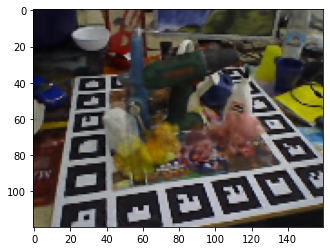

In [3]:
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)


down = 4
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

In [4]:
# down = 8 # trade off resolution+aliasing for render speed to make this video faster
# frames = []
# for i, c2w in enumerate(render_poses):
#     if i%8==0: print(i)
#     test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
#     frames.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
# print('done, saving')

# f = os.path.join(exp_dir, 'video.mp4')
# imageio.mimwrite(f, frames, fps=30, quality=8)

# from IPython.display import Video
# Video(f, height=320)

In [5]:
# %matplotlib inline
# from ipywidgets import interactive, widgets
# import matplotlib.pyplot as plt
# import numpy as np


# def f(x, y, z):
    
#     c2w = tf.convert_to_tensor([
#         [1,0,0,x],
#         [0,1,0,y],
#         [0,0,1,z],
#         [0,0,0,1],
#     ], dtype=tf.float32)
    
#     test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
#     img = np.clip(test[0],0,1)
    
#     plt.figure(2, figsize=(20,6))
#     plt.imshow(img)
#     plt.show()
    

# sldr = lambda : widgets.FloatSlider(
#     value=0.,
#     min=-1.,
#     max=1.,
#     step=.01,
# )

# names = ['x', 'y', 'z']
    
# interactive_plot = interactive(f, **{n : sldr() for n in names})
# interactive_plot

In [6]:
%matplotlib inline
from ipywidgets import interactive, widgets

down = 8

trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    print(f'**kwargs:{kwargs}')
    focal = kwargs['focal']
    del kwargs['focal']
    c2w = pose_spherical(**kwargs)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
#     img = depth
    # img = sigma
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
    continuous_update=False
)

names = [
    ['theta', [180., 0., 360]],
    ['phi', [-80., -90, 0]],
    ['radius', [1.5, 1., 10.]],
    ['focal', [584., 10., 1000.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=180.0, continuous_update=False, description='theta', max=360.0, step=0…